[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [102]:
import pandas as pd
import numpy as np
import warnings
import geopandas as gpd
from dbfread import DBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
import shap
import math
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold

### Load data

In [103]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### filter max and min of ros_p

In [104]:
#df = df[df["ros_p"] < 3000]
#df = df[df["ros_p"] > 500]

### remove nans from ros_p

In [105]:
n_before = len(df)
df = df.dropna(subset=['ros_p']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### convert categorical variables into "category" type

In [106]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Turn ros lags into log

In [107]:
log_base = 10

ros_lag_cols = [col for col in df.columns if col.startswith('ros_p_lg')]

for col in ros_lag_cols:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=ros_lag_cols, inplace=True)

### Select specific columns for modeling

In [108]:
c = [
    "duration_p",
    #"ros_p_lg1_log",
    "wv100_k_av",
    "3_8y_fir_p",
    "FWI_12h_av",
    "8_ny_fir_p",
    "f_load_av",
    "HDW_av",
    "CircVar",
    "landform",
    "gT_8_7_av",
    "sW_100_av",
    "wSv_1_av",
    "rh_950_av",
    "d_2m_C_av",
    "f_start",
    "BLH_m_rt",
    "wv10_kh_av",
    "aspect_av",
    "wv_850_av",
    "ros_p"
]

df = df[c]

# df = df[df["ros_p_lg1_log"].isna()]

### Drop top 10 vars with highest sum of correlation

In [109]:
# Select only numerical vars
num_df = df.select_dtypes(include=["number"])

# Calculate corr matrix
corr_matrix = num_df.corr()

# Sum of absolute correlations
corr_sum = corr_matrix.abs().sum()

# Sort by correlation sum
corr_sum = corr_sum.sort_values(ascending=False, kind="mergesort")

print(corr_sum)

"""# change number to change n of top vars to drop
drop = corr_sum.index[:5].tolist()

print("\nVariables removed:")
print(drop)

df = df.drop(columns=drop)"""

wv100_k_av    6.668973
wv10_kh_av    5.920350
wSv_1_av      5.900540
FWI_12h_av    5.353350
HDW_av        5.102552
sW_100_av     5.065075
wv_850_av     4.778060
ros_p         4.737105
d_2m_C_av     4.692395
rh_950_av     4.336709
CircVar       3.696596
gT_8_7_av     3.584491
8_ny_fir_p    3.514450
duration_p    3.370892
f_start       3.331368
BLH_m_rt      2.922495
f_load_av     2.770260
3_8y_fir_p    2.514787
aspect_av     2.295977
dtype: float64


'# change number to change n of top vars to drop\ndrop = corr_sum.index[:5].tolist()\n\nprint("\nVariables removed:")\nprint(drop)\n\ndf = df.drop(columns=drop)'

### Eliminate vars with >50% rows with nans

In [110]:
df = df.drop(
    columns=["EL_m_av", "Cin_av", "gT_s_9_av", "rh_700_av", "LiftIdx_av"],
    errors="ignore"
)

### Create test and train datasets

In [111]:
train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

# Create initial X and y
X = df[train_features]
y = df['ros_p']

### train on 100% of dataset

In [ ]:
param_dist = {
    'max_depth': [5, 7, 9, 11, 13, 15],               # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'colsample_bylevel': uniform(0.6, 0.4),           # column sampling per level (adds complexity)
    'colsample_bynode': uniform(0.6, 0.4),            # column sampling per node (adds complexity)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 3),                      # L2 regularization (increased range)
    'max_delta_step': randint(0, 5),                  # maximum delta step (helps with imbalanced data)
}

# XGBoost model with early stopping
base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               # faster histogram-based algorithm
    enable_categorical=True                           # handle categorical features better
)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Halving random search with more resources
xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=3000,                            
    min_resources=300,                           
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [113]:
log_mult = 7 #23.3139 
log_base = 20 #2.9637

y_log = log_mult *  np.log1p(y) / np.log(log_base)

# Train the model search 
xgb_random.fit(
    X, 
    y_log
)

# 5. RESULT
print("\nBest Cross-Validation Score (R2):", xgb_random.best_score_)

print("Trained on full dataset. Best model saved.")

final_model = xgb_random.best_estimator_
final_model.save_model("../../Data/Models/XGBoost.json")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 3000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 100
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 10
n_resources: 300
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 4
n_resources: 900
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 2700
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Cross-Validation Score (R2): 0.6311159718386874
Trained on full dataset. Best model saved.


### Randomly sample 10 rows to see model prediction and corresponding error

In [114]:
y_pred = final_model.predict(X)

inv_mult = np.log(log_base) / log_mult

y_pred_linear = np.exp(y_pred * inv_mult) - 1

sample_df = pd.DataFrame({
    'Actual ROS': y,
    'Predicted ROS': y_pred_linear
}).reset_index(drop=True)

# Randomly sample 10 rows
sample_10 = sample_df.sample(10).copy()

# Compute % error
sample_10['% Error'] = ((sample_10['Predicted ROS'] - sample_10['Actual ROS']) / sample_10['Actual ROS']) * 100

print("Sample of 10 predictions vs actual ROS values:\n")
display(sample_10)

Sample of 10 predictions vs actual ROS values:



Actual ROS  Predicted ROS    % Error
1078  2715.836049    2759.842656   1.620371
258     78.444995      87.856846  11.998026
179    975.775847     982.121710   0.650340
386    139.966966     147.685175   5.514308
968   1394.753804    1452.205893   4.119156
764     37.779276      43.710236  15.698977
911    399.229425     411.720509   3.128798
915    395.626376     363.766124  -8.053116
797   2481.787462    2123.348575 -14.442771
11     524.529661     543.382553   3.594247

### debugging

In [115]:
"""
este codigo faz mais ou menos o que esta acima mas 
manualmente e com mais outputs intermediarios. 
a diferença é que nao treino o modelo no dataset inteiro.
Sao feitos 5 folds, e no final feito uma media dos resultados e
graficos com todos os pontos juntos.
No codigo acima, também sao feitos os 5 folds, mas apenas para
descobrir os melhores hiperparametros. Depois o modelo é treinado
no dataset inteiro com esses hiperparametros.
"""

param_dist = {
    'max_depth': [5, 7, 9, 11, 13, 15],               # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'colsample_bylevel': uniform(0.6, 0.4),           # column sampling per level (adds complexity)
    'colsample_bynode': uniform(0.6, 0.4),            # column sampling per node (adds complexity)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 3),                      # L2 regularization (increased range)
    'max_delta_step': randint(0, 5),                  # maximum delta step (helps with imbalanced data)
}

# XGBoost model with early stopping
base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               # faster histogram-based algorithm
    early_stopping_rounds=50,                         # stop if no improvement
    enable_categorical=True                           # handle categorical features better
)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Halving random search with more resources
xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=3000,                            
    min_resources=300,                           
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
# 1. PREPARE FEATURES AND TARGET
# Define features (excluding specific columns)
train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

# Create initial X and y
X = df[train_features].copy()
y = df['ros_p'].copy()

# 2. FILTER INVALID TARGETS GLOBALLY
# It is best to remove invalid targets (-1) BEFORE cross-validation 
# to avoid index mismatch errors inside the loop.
valid_mask = y != -1
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"Total valid samples for Cross-Validation: {len(X)}")

# 4. INITIALIZE TRACKING FOR AVERAGED RESULTS
fold_metrics = []
all_y_test_log = []
all_y_pred_log = []
all_y_test_linear = []
all_y_pred_linear = []
all_feature_importances = []

# 5. THE CROSS-VALIDATION LOOP
fold = 1
for train_index, test_index in kf.split(X, y):
    print(f"--- Processing Fold {fold} ---")
    
    # Split the data based on the current fold's indices
    X_train_final, X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train_final, y_test_final = y.iloc[train_index], y.iloc[test_index]

    # modify constants below in order to change transformation of ros_p. (don't forget to apply the same transformation to ros_p lags above)
    log_mult = 7 #23.3139 
    log_base = 20 #2.9637

    y_train_log = log_mult *  np.log1p(y_train_final) / np.log(log_base)
    y_test_log = log_mult * np.log1p(y_test_final) / np.log(log_base)

    
    print(f"  Train size: {len(X_train_final)}")
    print(f"  Test size:  {len(X_test_final)}")
    
    # Train the model search with validation set for early stopping
    xgb_random.fit(
        X_train_final, 
        y_train_log,
        eval_set=[(X_train_final, y_train_log)]
    )

    # Get the best model and parameters
    print(f"\nSearch complete.")
    print(f"Best parameters found: {xgb_random.best_params_}")
    best_model = xgb_random.best_estimator_

    # Make predictions with the best model
    y_pred_log = best_model.predict(X_test_final)
    y_pred = np.expm1(y_pred_log)

    # Inverse transform log to linear
    inv_mult = np.log(log_base) / log_mult
    y_test_linear = np.exp(y_test_log * inv_mult) - 1
    y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

    # Metrics in log space
    r2 = r2_score(y_test_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
    mae_log = mean_absolute_error(y_test_log, y_pred_log)

    # Metrics in linear space
    rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
    mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

    # Store metrics for averaging
    fold_metrics.append({
        'fold': fold,
        'r2': r2,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'rmse_linear': rmse_linear,
        'mae_linear': mae_linear,
        'n_estimators': best_model.n_estimators,
        'max_depth': best_model.max_depth
    })

    # Store predictions for combined plot
    all_y_test_log.extend(y_test_log.tolist())
    all_y_pred_log.extend(y_pred_log.tolist())
    all_y_test_linear.extend(y_test_linear.tolist())
    all_y_pred_linear.extend(y_pred_linear.tolist())

    # Feature importance
    feature_names = X_train_final.columns.tolist()
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)
    all_feature_importances.append(importances)

    print("\nLog scale metrics:")
    print(f"R2 Score (log): {r2:.4f}")
    print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
    print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")
    print(f"\nBest n_estimators: {best_model.n_estimators}")
    print(f"Best max_depth: {best_model.max_depth}")

    # Plot feature importance
    plt.figure(figsize=(8, 6))
    plt.bar(importances['feature'][:20], importances['importance'][:20])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 20 Most Important Features - Fold {fold} (XGBoost)')
    plt.tight_layout()
    plt.show()

    print("\nTop 20 Most Important Features:")
    print(importances.head(20))

    # Predicted vs Actual scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

    # Perfect prediction line
    min_val = min(y_test_log.min(), y_pred_log.min())
    max_val = max(y_test_log.max(), y_pred_log.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.title(f'Fold {fold}: Predicted vs Actual Fire Spread Rate (ROS) - XGBoost', fontsize=14)
    plt.xlabel('Actual ROS (m/h)', fontsize=12)
    plt.ylabel('Predicted ROS (m/h)', fontsize=12)

    # Add metrics annotation with both log and linear scales
    plt.text(0.05, 0.95, 
        f'R² = {r2:.3f}\n'
        f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
        f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
        transform=plt.gca().transAxes, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # inverse-transform scaling factor
    inv_mult = np.log(log_base) / log_mult

    def tick_formatter_log_to_linear(x, pos):
        """Formats tick: log_value  (linear_value)"""
        linear_val = np.exp(x * inv_mult) - 1
        return f"{x:.2f}\n({linear_val:.0f})"

    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
    fold += 1

# ========================================
# 6. FINAL AVERAGED RESULTS
# ========================================
print("\n" + "="*60)
print("FINAL CROSS-VALIDATION RESULTS (AVERAGED ACROSS ALL FOLDS)")
print("="*60)

# Create metrics dataframe
metrics_df = pd.DataFrame(fold_metrics)
print("\nPer-Fold Metrics:")
print(metrics_df.to_string(index=False))

# Calculate averages
avg_metrics = metrics_df.mean(numeric_only=True)
std_metrics = metrics_df.std(numeric_only=True)

print("\n" + "-"*60)
print("AVERAGE METRICS:")
print("-"*60)
print(f"R² Score (log):        {avg_metrics['r2']:.4f} ± {std_metrics['r2']:.4f}")
print(f"RMSE (log):            {avg_metrics['rmse_log']:.4f} ± {std_metrics['rmse_log']:.4f}")
print(f"MAE (log):             {avg_metrics['mae_log']:.4f} ± {std_metrics['mae_log']:.4f}")
print(f"RMSE (linear):         {avg_metrics['rmse_linear']:.1f} ± {std_metrics['rmse_linear']:.1f}")
print(f"MAE (linear):          {avg_metrics['mae_linear']:.1f} ± {std_metrics['mae_linear']:.1f}")
print(f"Avg n_estimators:      {avg_metrics['n_estimators']:.1f}")
print(f"Avg max_depth:         {avg_metrics['max_depth']:.1f}")

# Average feature importances across all folds
avg_feature_importance = pd.concat(all_feature_importances).groupby('feature')['importance'].mean()
avg_feature_importance = avg_feature_importance.sort_values(ascending=False).reset_index()
avg_feature_importance.columns = ['feature', 'importance']

print("\n" + "-"*60)
print("TOP 20 MOST IMPORTANT FEATURES (AVERAGED):")
print("-"*60)
print(avg_feature_importance.head(20).to_string(index=False))

# Plot averaged feature importance
plt.figure(figsize=(10, 6))
plt.bar(avg_feature_importance['feature'][:20], avg_feature_importance['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features - Averaged Across All Folds (XGBoost)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average Importance', fontsize=12)
plt.tight_layout()
plt.show()

# Convert to numpy arrays for overall metrics
all_y_test_log = np.array(all_y_test_log)
all_y_pred_log = np.array(all_y_pred_log)
all_y_test_linear = np.array(all_y_test_linear)
all_y_pred_linear = np.array(all_y_pred_linear)

# Calculate overall metrics on all predictions combined
overall_r2 = r2_score(all_y_test_log, all_y_pred_log)
overall_rmse_log = np.sqrt(mean_squared_error(all_y_test_log, all_y_pred_log))
overall_mae_log = mean_absolute_error(all_y_test_log, all_y_pred_log)
overall_rmse_linear = np.sqrt(mean_squared_error(all_y_test_linear, all_y_pred_linear))
overall_mae_linear = mean_absolute_error(all_y_test_linear, all_y_pred_linear)

print("\n" + "-"*60)
print("OVERALL METRICS (ALL PREDICTIONS COMBINED):")
print("-"*60)
print(f"R² Score (log):        {overall_r2:.4f}")
print(f"RMSE (log):            {overall_rmse_log:.4f}")
print(f"MAE (log):             {overall_mae_log:.4f}")
print(f"RMSE (linear):         {overall_rmse_linear:.1f}")
print(f"MAE (linear):          {overall_mae_linear:.1f}")

# Final combined scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(all_y_test_log, all_y_pred_log, alpha=0.5, edgecolor='k', s=30)

# Perfect prediction line
min_val = min(all_y_test_log.min(), all_y_pred_log.min())
max_val = max(all_y_test_log.max(), all_y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Combined: Predicted vs Actual Fire Spread Rate (All Folds)', fontsize=16, fontweight='bold')
plt.xlabel('Actual ROS (m/h)', fontsize=13)
plt.ylabel('Predicted ROS (m/h)', fontsize=13)

# Add metrics annotation
metrics_text = (
    f'Overall Metrics (All Folds Combined):\n'
    f'R² = {overall_r2:.3f}\n'
    f'RMSE = {overall_rmse_log:.2f} ({overall_rmse_linear:.1f})\n'
    f'MAE = {overall_mae_log:.2f} ({overall_mae_linear:.1f})\n'
    f'N samples = {len(all_y_test_log)}'
)
plt.text(0.05, 0.95, 
    metrics_text, 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10)

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CROSS-VALIDATION COMPLETE")
print("="*60)

Total valid samples for Cross-Validation: 1173
--- Processing Fold 1 ---
  Train size: 938
  Test size:  235
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 300
max_resources_: 3000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 300
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:2.51963
[0]	validation_0-rmse:2.51916
[1]	validation_0-rmse:2.46084
[0]	validation_0-rmse:2.52003
[0]	validation_0-rmse:2.51623
[1]	validation_0-rmse:2.46124
[1]	validation_0-rmse:2.46115
[2]	validation_0-rmse:2.40589
[2]	validation_0-rmse:2.40510
[2]	validation_0-rmse:2.40448
[3]	validation_0-rmse:2.34874
[1]	validation_0-rmse:2.45681
[3]	validation_0-rmse:2.34793
[3]	validation_0-rmse:2.34598
[4]	validation_0-rmse:2.29543
[4]	validation_0-rmse:2.29300
[4]	validation_0-rmse:2.28691
[2]	validation_0-rmse:2.40539
[5]	validation_0-rmse:2.23883
[5]	validation_0-rmse:2.23189
[5]	validation_0-rmse:2.24455


KeyboardInterrupt: 

### Residuals analysis in log and linear scales


RESIDUAL ANALYSIS

RESIDUAL STATISTICS (Log Scale):
Mean Residual:        -0.0072
Median Residual:      0.0206
Std Dev Residual:     1.5600
Min Residual:         -6.8619
Max Residual:         4.6839

RESIDUAL STATISTICS (Linear Scale):
Mean Residual:        153.23 m/h
Median Residual:      3.22 m/h
Std Dev Residual:     758.93 m/h
Min Residual:         -3023.58 m/h
Max Residual:         6039.22 m/h

Predictions within ±0.5 (log):   27.3%
Predictions within ±1.0 (log):   50.0%
Predictions within ±2.0 (log):   81.2%

Predictions within ±10 m/h:   4.5%
Predictions within ±50 m/h:   19.4%
Predictions within ±100 m/h:  31.7%

------------------------------------------------------------
SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):
------------------------------------------------------------

Range (log)     Count      Mean Error      RMSE           
------------------------------------------------------------
8-10            3             +0.5074           0.6073
10+    

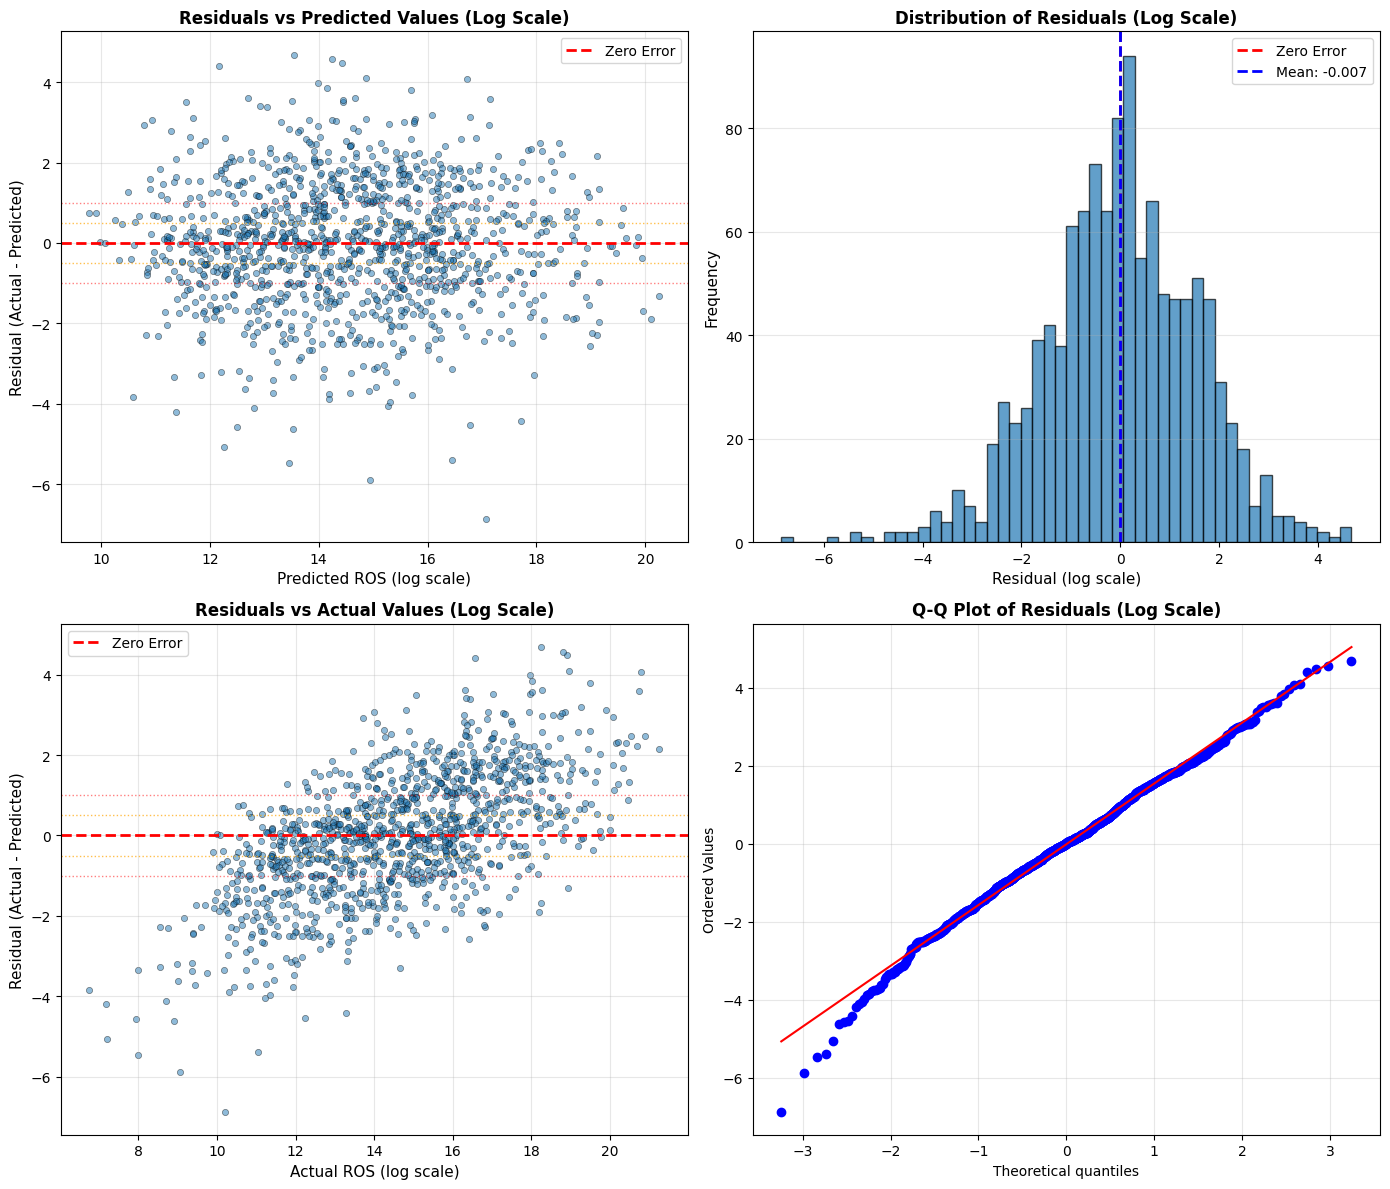

Residuals Plots (Linear Scale)


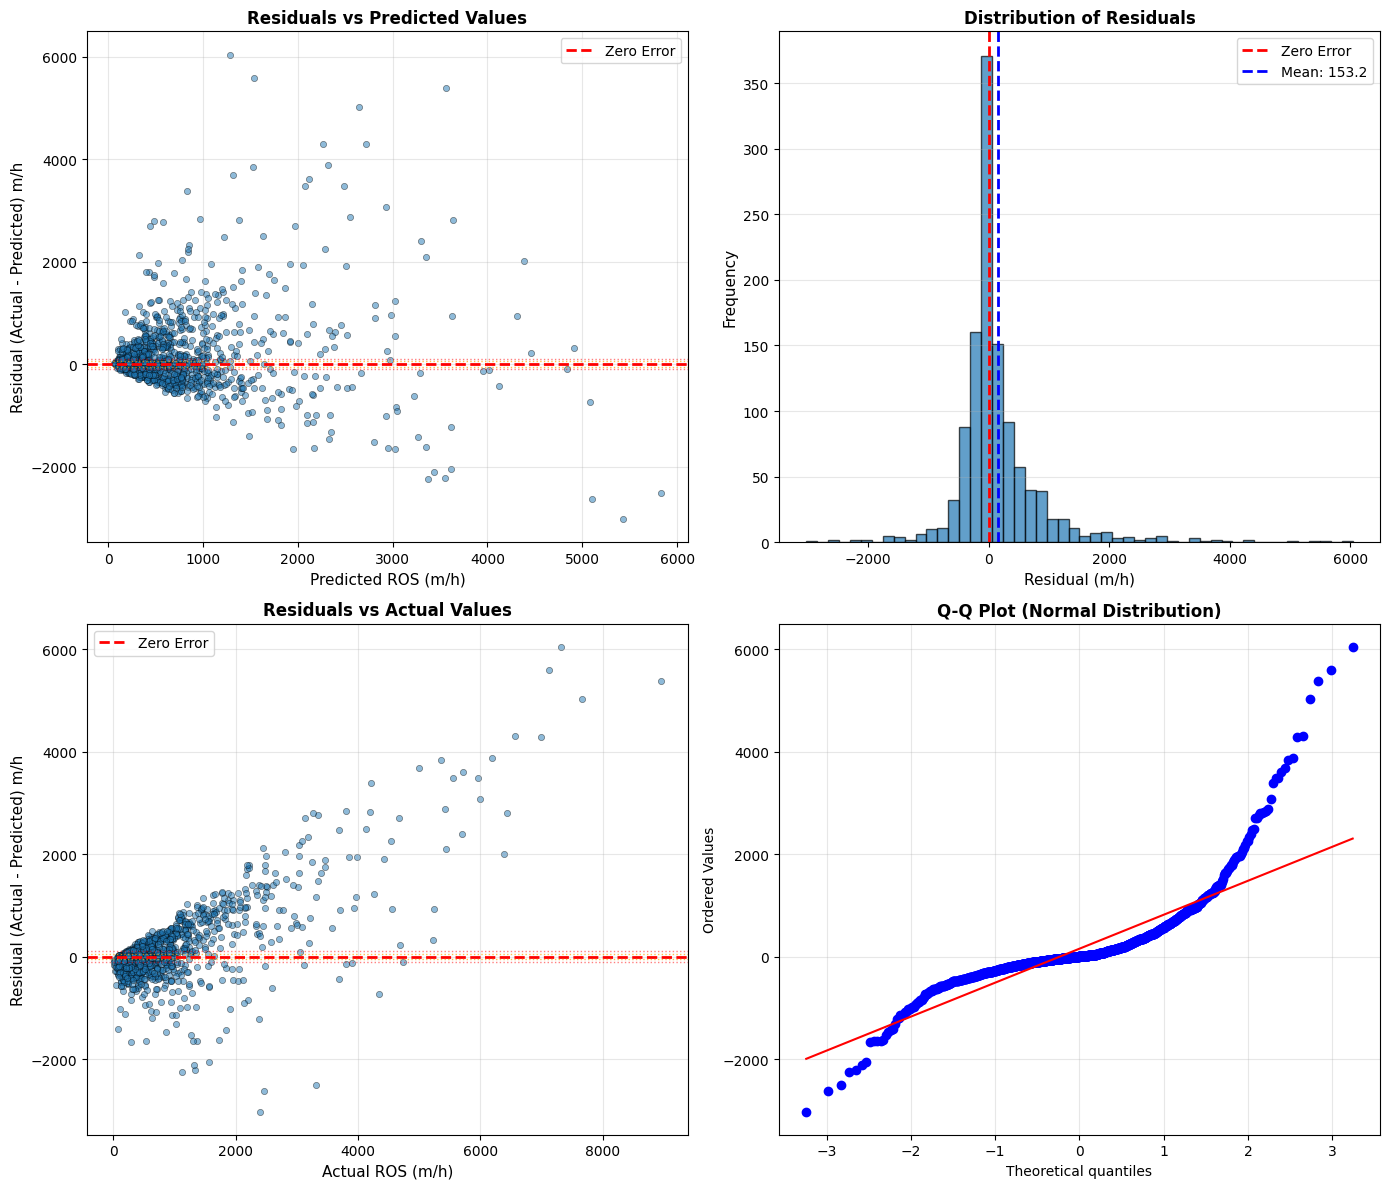


PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):
Mean Percentage Error:    -28.05%
Median Percentage Error:  +0.88%
Std Dev Percentage Error: 119.47%

SYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by 153.2 m/h on average


In [ ]:
# ========================================
# RESIDUAL ANALYSIS AND SYSTEMATIC ERRORS
# ========================================
print("\n" + "="*60)
print("RESIDUAL ANALYSIS")
print("="*60)

# Calculate residuals in both scales
residuals_log = all_y_test_log - all_y_pred_log
residuals_linear = all_y_test_linear - all_y_pred_linear

# Basic residual statistics - LOG SCALE
print("\nRESIDUAL STATISTICS (Log Scale):")
print(f"Mean Residual:        {np.mean(residuals_log):.4f}")
print(f"Median Residual:      {np.median(residuals_log):.4f}")
print(f"Std Dev Residual:     {np.std(residuals_log):.4f}")
print(f"Min Residual:         {np.min(residuals_log):.4f}")
print(f"Max Residual:         {np.max(residuals_log):.4f}")

# Basic residual statistics - LINEAR SCALE
print("\nRESIDUAL STATISTICS (Linear Scale):")
print(f"Mean Residual:        {np.mean(residuals_linear):.2f} m/h")
print(f"Median Residual:      {np.median(residuals_linear):.2f} m/h")
print(f"Std Dev Residual:     {np.std(residuals_linear):.2f} m/h")
print(f"Min Residual:         {np.min(residuals_linear):.2f} m/h")
print(f"Max Residual:         {np.max(residuals_linear):.2f} m/h")

# Percentage of predictions within certain error bounds - LOG SCALE
within_0_5_log = np.sum(np.abs(residuals_log) <= 0.5) / len(residuals_log) * 100
within_1_log = np.sum(np.abs(residuals_log) <= 1.0) / len(residuals_log) * 100
within_2_log = np.sum(np.abs(residuals_log) <= 2.0) / len(residuals_log) * 100

print(f"\nPredictions within ±0.5 (log):   {within_0_5_log:.1f}%")
print(f"Predictions within ±1.0 (log):   {within_1_log:.1f}%")
print(f"Predictions within ±2.0 (log):   {within_2_log:.1f}%")

# Percentage of predictions within certain error bounds - LINEAR SCALE
within_10 = np.sum(np.abs(residuals_linear) <= 10) / len(residuals_linear) * 100
within_50 = np.sum(np.abs(residuals_linear) <= 50) / len(residuals_linear) * 100
within_100 = np.sum(np.abs(residuals_linear) <= 100) / len(residuals_linear) * 100

print(f"\nPredictions within ±10 m/h:   {within_10:.1f}%")
print(f"Predictions within ±50 m/h:   {within_50:.1f}%")
print(f"Predictions within ±100 m/h:  {within_100:.1f}%")

# Systematic error analysis - binned predictions - LOG SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):")
print("-"*60)

# Create bins for analysis in log space
bins_log = [0, 2, 4, 6, 8, 10, np.inf]
bin_labels_log = ['0-2', '2-4', '4-6', '6-8', '8-10', '10+']

# Assign bins to predictions
bin_indices_log = np.digitize(all_y_pred_log, bins_log) - 1

print(f"\n{'Range (log)':<15} {'Count':<10} {'Mean Error':<15} {'RMSE':<15}")
print("-" * 60)

for i, label in enumerate(bin_labels_log):
    mask = bin_indices_log == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_log[mask])
        rmse_bin = np.sqrt(np.mean(residuals_log[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.4f}       {rmse_bin:>10.4f}")

# Systematic error analysis - binned predictions - LINEAR SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LINEAR SCALE):")
print("-"*60)

# Create bins for analysis
bins = [0, 50, 100, 200, 500, 1000, np.inf]
bin_labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']

# Assign bins to predictions
bin_indices = np.digitize(all_y_pred_linear, bins) - 1

print(f"\n{'Range (m/h)':<15} {'Count':<10} {'Mean Error':<15} {'Mean % Error':<15} {'RMSE':<15}")
print("-" * 70)

for i, label in enumerate(bin_labels):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_linear[mask])
        mean_pct_error = np.mean((residuals_linear[mask] / all_y_test_linear[mask]) * 100)
        rmse_bin = np.sqrt(np.mean(residuals_linear[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.2f} m/h  {mean_pct_error:>+10.1f}%     {rmse_bin:>10.2f} m/h")

# ========================================
# RESIDUAL PLOTS - LOG SCALE
# ========================================
print("Residual Plots (Log Scale)")

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values (Log)
axes1[0, 0].scatter(all_y_pred_log, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 0].set_xlabel('Predicted ROS (log scale)', fontsize=11)
axes1[0, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[0, 0].set_title('Residuals vs Predicted Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 0].grid(True, alpha=0.3)
axes1[0, 0].legend()

# Add reference lines for ±0.5, ±1.0 log units
axes1[0, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[0, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals (Log)
axes1[0, 1].hist(residuals_log, bins=50, edgecolor='black', alpha=0.7)
axes1[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 1].axvline(x=np.mean(residuals_log), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_log):.3f}')
axes1[0, 1].set_xlabel('Residual (log scale)', fontsize=11)
axes1[0, 1].set_ylabel('Frequency', fontsize=11)
axes1[0, 1].set_title('Distribution of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 1].legend()
axes1[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values (Log)
axes1[1, 0].scatter(all_y_test_log, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[1, 0].set_xlabel('Actual ROS (log scale)', fontsize=11)
axes1[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[1, 0].set_title('Residuals vs Actual Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 0].grid(True, alpha=0.3)
axes1[1, 0].legend()

# Add reference lines
axes1[1, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[1, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (to check normality of residuals) - Log
from scipy import stats
stats.probplot(residuals_log, dist="norm", plot=axes1[1, 1])
axes1[1, 1].set_title('Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# RESIDUAL PLOTS - LINEAR SCALE
# ========================================
print("Residuals Plots (Linear Scale)")

# 1. Residual vs Predicted (Linear Scale)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values
axes[0, 0].scatter(all_y_pred_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].set_xlabel('Predicted ROS (m/h)', fontsize=11)
axes[0, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add reference lines for ±50 and ±100 m/h errors
axes[0, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[0, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals
axes[0, 1].hist(residuals_linear, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=np.mean(residuals_linear), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_linear):.1f}')
axes[0, 1].set_xlabel('Residual (m/h)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values
axes[1, 0].scatter(all_y_test_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].set_xlabel('Actual ROS (m/h)', fontsize=11)
axes[1, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[1, 0].set_title('Residuals vs Actual Values', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Add reference lines
axes[1, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (to check normality of residuals)
from scipy import stats
stats.probplot(residuals_linear, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# PERCENTAGE ERROR ANALYSIS
# ========================================

# Calculate percentage errors (avoiding division by very small numbers)
mask_nonzero = all_y_test_linear > 1  # Only consider actual values > 1 m/h
pct_errors = (residuals_linear[mask_nonzero] / all_y_test_linear[mask_nonzero]) * 100

print("\n" + "="*60)
print("PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):")
print("="*60)
print(f"Mean Percentage Error:    {np.mean(pct_errors):+.2f}%")
print(f"Median Percentage Error:  {np.median(pct_errors):+.2f}%")
print(f"Std Dev Percentage Error: {np.std(pct_errors):.2f}%")

# Systematic bias check
if np.abs(np.mean(residuals_linear)) > 5:
    if np.mean(residuals_linear) > 0:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by {np.mean(residuals_linear):.1f} m/h on average")
    else:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to OVERPREDICT by {np.abs(np.mean(residuals_linear)):.1f} m/h on average")
else:
    print(f"\n✓ No significant systematic bias detected (mean error: {np.mean(residuals_linear):.1f} m/h)")

### 95% quantile residuals

Loading dataset...
Dataset loaded

95th Percentile of Absolute Residuals (log): 3.0824
Number of outlier observations: 59 (5.0% of data)

------------------------------------------------------------------------------------------------------------------------
MATCHING OUTLIERS TO ORIGINAL DATAFRAME...
------------------------------------------------------------------------------------------------------------------------

Successfully matched 59 out of 59 outliers

--------------------------------------------------------------------------------------------------------------------------------------------
TOP 50 WORST PREDICTIONS WITH ORIGINAL DATAFRAME INDICES:
--------------------------------------------------------------------------------------------------------------------------------------------
DF_Idx     CV_Idx   Actual(m/h)  Pred(m/h)    Error(m/h)   %Error     Abs_Res_Log 
-------------------------------------------------------------------------------------------------------------

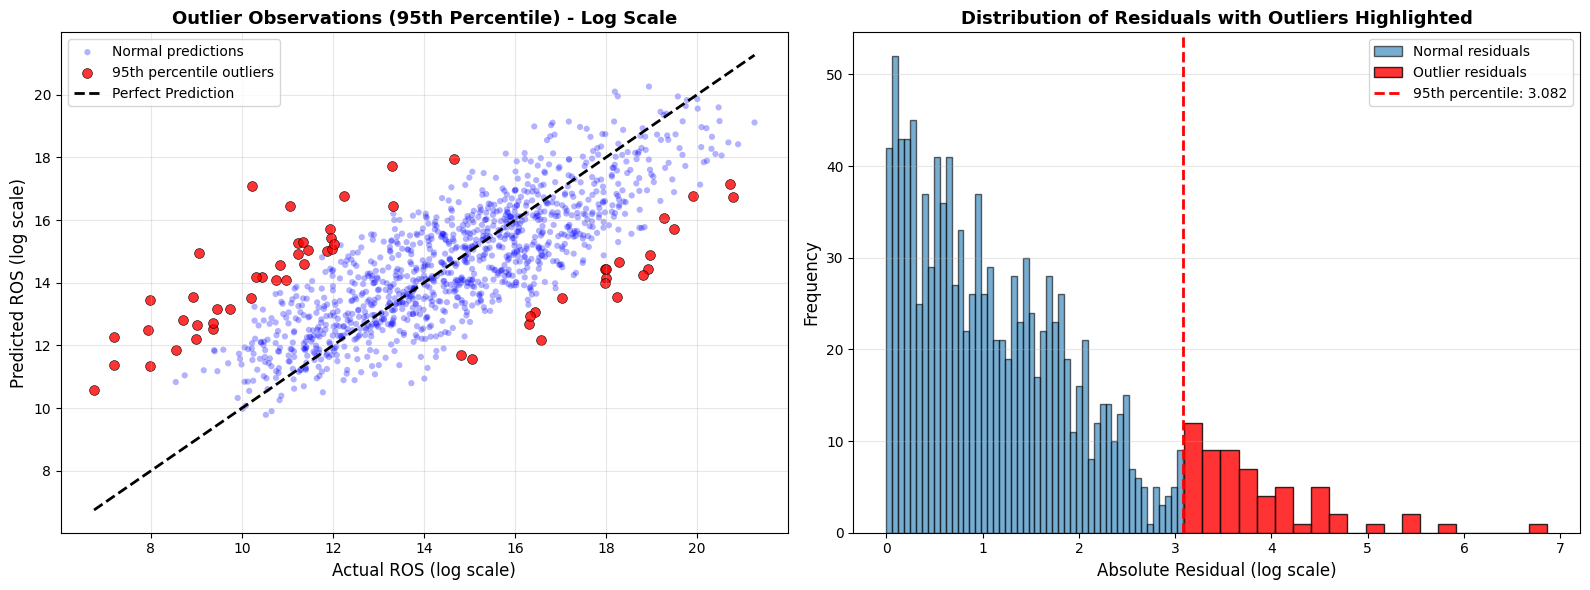


OUTLIER ANALYSIS COMPLETE


In [ ]:
"""
Obter as observações com maiores residuos e dar trace para o shp original 
para poder investigar pq é que o modelo está a falhar.

Primeiro vamos importar o shp "final" em vez do "model"
"""

print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise


# Calculate absolute residuals in log scale
abs_residuals_log = np.abs(residuals_log)

# Find the 95th percentile threshold
percentile_95 = np.percentile(abs_residuals_log, 95)
print(f"\n95th Percentile of Absolute Residuals (log): {percentile_95:.4f}")

# Find observations beyond 95th percentile
outlier_mask = abs_residuals_log >= percentile_95
outlier_indices = np.where(outlier_mask)[0]

print(f"Number of outlier observations: {len(outlier_indices)} ({len(outlier_indices)/len(residuals_log)*100:.1f}% of data)")

# Create a dataframe with outlier details
outlier_data = pd.DataFrame({
    'CV_Index': outlier_indices,
    'Actual_Log': all_y_test_log[outlier_mask],
    'Predicted_Log': all_y_pred_log[outlier_mask],
    'Residual_Log': residuals_log[outlier_mask],
    'Abs_Residual_Log': abs_residuals_log[outlier_mask],
    'Actual_Linear': all_y_test_linear[outlier_mask],
    'Predicted_Linear': all_y_pred_linear[outlier_mask],
    'Residual_Linear': residuals_linear[outlier_mask],
    'Percent_Error': (residuals_linear[outlier_mask] / all_y_test_linear[outlier_mask]) * 100
})

# Sort by absolute residual (largest errors first)
outlier_data = outlier_data.sort_values('Abs_Residual_Log', ascending=False)

print("\n" + "-"*120)
print("MATCHING OUTLIERS TO ORIGINAL DATAFRAME...")
print("-"*120)

# Match outliers back to original dataframe using ros_p values
# Since we filtered valid_mask earlier, we need to work with the filtered data
matched_outliers = []

for idx, row in outlier_data.iterrows():
    actual_ros = row['Actual_Linear']
    
    # Find matching rows in original df with same ros_p value
    # Use a small tolerance for floating point comparison
    tolerance = 0.01
    matches = df[np.abs(df['ros_p'] - actual_ros) < tolerance]
    
    if len(matches) > 0:
        # If multiple matches, try to narrow down by taking first match
        # In practice, you might have unique identifiers to use instead
        match_idx = matches.index[0]
        
        matched_outliers.append({
            'DF_Index': match_idx,
            'CV_Index': row['CV_Index'],
            'Actual_ROS': actual_ros,
            'Predicted_ROS': row['Predicted_Linear'],
            'Error': row['Residual_Linear'],
            'Percent_Error': row['Percent_Error'],
            'Abs_Residual_Log': row['Abs_Residual_Log']
        })
    else:
        # If no exact match found, still record it
        matched_outliers.append({
            'DF_Index': 'NOT_FOUND',
            'CV_Index': row['CV_Index'],
            'Actual_ROS': actual_ros,
            'Predicted_ROS': row['Predicted_Linear'],
            'Error': row['Residual_Linear'],
            'Percent_Error': row['Percent_Error'],
            'Abs_Residual_Log': row['Abs_Residual_Log']
        })

matched_df = pd.DataFrame(matched_outliers)

print(f"\nSuccessfully matched {len(matched_df[matched_df['DF_Index'] != 'NOT_FOUND'])} out of {len(matched_df)} outliers")

print("\n" + "-"*140)
print("TOP 50 WORST PREDICTIONS WITH ORIGINAL DATAFRAME INDICES:")
print("-"*140)
print(f"{'DF_Idx':<10} {'CV_Idx':<8} {'Actual(m/h)':<12} {'Pred(m/h)':<12} {'Error(m/h)':<12} {'%Error':<10} {'Abs_Res_Log':<12}")
print("-"*140)

for idx, row in matched_df.head(50).iterrows():
    df_idx_str = str(row['DF_Index']) if row['DF_Index'] != 'NOT_FOUND' else 'NOT_FOUND'
    print(f"{df_idx_str:<10} "
          f"{int(row['CV_Index']):<8} "
          f"{row['Actual_ROS']:>11.1f} "
          f"{row['Predicted_ROS']:>11.1f} "
          f"{row['Error']:>+11.1f} "
          f"{row['Percent_Error']:>+9.1f}% "
          f"{row['Abs_Residual_Log']:>11.4f}")

# ========================================
# ADD OUTLIER INFORMATION TO ORIGINAL DATAFRAME
# ========================================
print("\n" + "="*60)
print("ADDING OUTLIER FLAGS TO ORIGINAL DATAFRAME")
print("="*60)

# Initialize outlier column as False for all rows
df['outlier'] = False

# Initialize prediction columns with NaN
df['Pred_ROS'] = np.nan
df['Pred_Error'] = np.nan
df['Pct_Error'] = np.nan

# Get valid outlier indices
valid_outlier_indices = matched_df[matched_df['DF_Index'] != 'NOT_FOUND']['DF_Index'].tolist()

if len(valid_outlier_indices) > 0:
    # Mark outliers as True
    df.loc[valid_outlier_indices, 'outlier'] = True
    
    # Add prediction information for outliers
    df.loc[valid_outlier_indices, 'Pred_ROS'] = matched_df[matched_df['DF_Index'] != 'NOT_FOUND']['Predicted_ROS'].values
    df.loc[valid_outlier_indices, 'Pred_Error'] = matched_df[matched_df['DF_Index'] != 'NOT_FOUND']['Error'].values
    df.loc[valid_outlier_indices, 'Pct_Error'] = matched_df[matched_df['DF_Index'] != 'NOT_FOUND']['Percent_Error'].values
    
    print(f"\nMarked {len(valid_outlier_indices)} observations as outliers in the dataframe")
    print(f"Added columns: 'outlier', 'Pred_ROS', 'Pred_Error', 'Pct_Error'")
    
    # Statistical summary of outliers
    outlier_subset = df[df['outlier'] == True]
    
    print("\n" + "-"*60)
    print("OUTLIER SUMMARY STATISTICS:")
    print("-"*60)
    print(f"Total observations in df:     {len(df)}")
    print(f"Number of outliers:           {len(outlier_subset)} ({len(outlier_subset)/len(df)*100:.2f}%)")
    print(f"Mean Actual ROS (outliers):   {outlier_subset['ros_p'].mean():.1f} m/h")
    print(f"Mean Predicted ROS:           {outlier_subset['Pred_ROS'].mean():.1f} m/h")
    print(f"Mean Absolute Error:          {np.abs(outlier_subset['Pred_Error']).mean():.1f} m/h")
    print(f"Mean Percentage Error:        {outlier_subset['Pct_Error'].mean():+.1f}%")
    
    # Check if model tends to over or underpredict for outliers
    underpredictions = outlier_subset[outlier_subset['Pred_Error'] > 0]
    overpredictions = outlier_subset[outlier_subset['Pred_Error'] < 0]
    
    print(f"\nUnderpredictions (model too low):  {len(underpredictions)} ({len(underpredictions)/len(outlier_subset)*100:.1f}%)")
    print(f"Overpredictions (model too high):  {len(overpredictions)} ({len(overpredictions)/len(outlier_subset)*100:.1f}%)")
    
    # Display key features for top 10 worst predictions
    print("\n" + "-"*60)
    print("TOP 10 WORST PREDICTIONS - KEY FEATURES:")
    print("-"*60)
    
    # Select important columns to display
    display_cols = ['ros_p', 'Pred_ROS', 'Pred_Error', 'Pct_Error', 'outlier']
    
    # Add some feature columns if they exist
    possible_features = ['inidoy', 'enddoy', 'wind_speed', 'temperature', 'humidity', 
                        'fuel_type', 'slope', 'aspect']
    for col in possible_features:
        if col in df.columns:
            display_cols.append(col)
    
    # Get columns that actually exist
    display_cols = [col for col in display_cols if col in df.columns]
    
    print("\nShowing available columns:", display_cols)
    
    # Get top 10 worst predictions (sort by absolute error)
    top_outliers = outlier_subset.reindex(valid_outlier_indices).head(10)
    print(top_outliers[display_cols].to_string(index=True))
    
    # Save the complete dataframe with outlier flags to shapefile
    save_shp = True  
    if save_shp:
        output_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_outliers.shp'
        
        # Shapefile column names are limited to 10 characters, so we need to handle this
        # Create a copy with shorter column names if necessary
        df_to_save = df.copy()
        
        # Rename new columns to fit shapefile constraints (max 10 chars)
        column_mapping = {
            'Pred_ROS': 'PredROS',
            'Pred_Error': 'PredErr',
            'Pct_Error': 'PctErr'
        }
        df_to_save.rename(columns=column_mapping, inplace=True)
        
        df_to_save.to_file(output_path)
        print(f"\n✓ Complete dataframe with outlier flags saved to:")
        print(f"  {output_path}")
        print(f"\nNew columns added:")
        print(f"  - outlier: Boolean (True for 95th percentile worst predictions)")
        print(f"  - PredROS: Predicted ROS value (m/h)")
        print(f"  - PredErr: Prediction error (Actual - Predicted)")
        print(f"  - PctErr: Percentage error")
    else:
        print("\n💡 To save the shapefile with outlier flags, set save_shp = True")
    
    # Create a reference variable for easy access to outliers
    print("\n" + "="*60)
    print("QUICK ACCESS:")
    print("="*60)
    print("To access outliers: df[df['outlier'] == True]")
    print("To access normal observations: df[df['outlier'] == False]")
    print("Or examine specific observations: df.loc[<DF_Index>]")
    
else:
    print("\nWarning: Could not match outliers back to original dataframe")
    print("This might happen if ros_p values were modified or filtered differently")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot highlighting outliers
axes[0].scatter(all_y_test_log[~outlier_mask], all_y_pred_log[~outlier_mask], 
                alpha=0.3, s=20, c='blue', label='Normal predictions', edgecolor='none')
axes[0].scatter(all_y_test_log[outlier_mask], all_y_pred_log[outlier_mask], 
                alpha=0.8, s=50, c='red', label='95th percentile outliers', edgecolor='black', linewidth=0.5)

# Perfect prediction line
min_val = min(all_y_test_log.min(), all_y_pred_log.min())
max_val = max(all_y_test_log.max(), all_y_pred_log.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

axes[0].set_xlabel('Actual ROS (log scale)', fontsize=12)
axes[0].set_ylabel('Predicted ROS (log scale)', fontsize=12)
axes[0].set_title('Outlier Observations (95th Percentile) - Log Scale', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution comparison
axes[1].hist(abs_residuals_log[~outlier_mask], bins=50, alpha=0.6, label='Normal residuals', edgecolor='black')
axes[1].hist(abs_residuals_log[outlier_mask], bins=20, alpha=0.8, color='red', label='Outlier residuals', edgecolor='black')
axes[1].axvline(x=percentile_95, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.3f}')
axes[1].set_xlabel('Absolute Residual (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals with Outliers Highlighted', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OUTLIER ANALYSIS COMPLETE")
print("="*60)

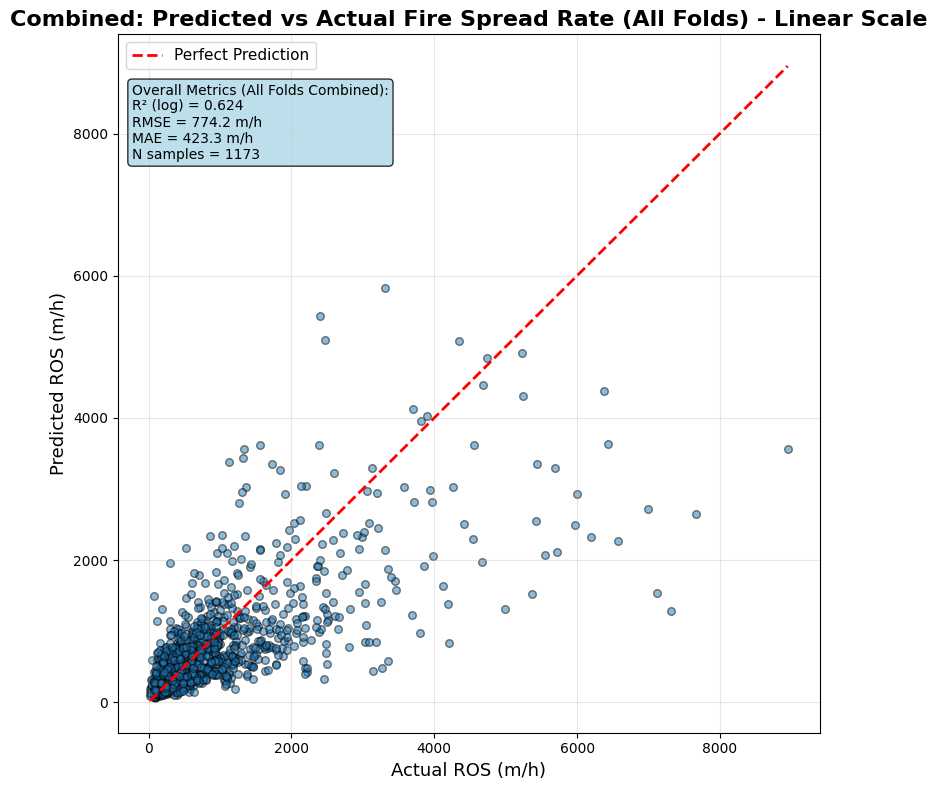


CROSS-VALIDATION COMPLETE


In [ ]:
# Final combined scatter plot - LINEAR SCALE
plt.figure(figsize=(8, 8))
plt.scatter(all_y_test_linear, all_y_pred_linear, alpha=0.5, edgecolor='k', s=30)

# Perfect prediction line
min_val_linear = min(all_y_test_linear.min(), all_y_pred_linear.min())
max_val_linear = max(all_y_test_linear.max(), all_y_pred_linear.max())
plt.plot([min_val_linear, max_val_linear], [min_val_linear, max_val_linear], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Combined: Predicted vs Actual Fire Spread Rate (All Folds) - Linear Scale', fontsize=16, fontweight='bold')
plt.xlabel('Actual ROS (m/h)', fontsize=13)
plt.ylabel('Predicted ROS (m/h)', fontsize=13)

# Add metrics annotation
metrics_text = (
    f'Overall Metrics (All Folds Combined):\n'
    f'R² (log) = {overall_r2:.3f}\n'
    f'RMSE = {overall_rmse_linear:.1f} m/h\n'
    f'MAE = {overall_mae_linear:.1f} m/h\n'
    f'N samples = {len(all_y_test_linear)}'
)
plt.text(0.02, 0.93, 
    metrics_text, 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10)

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

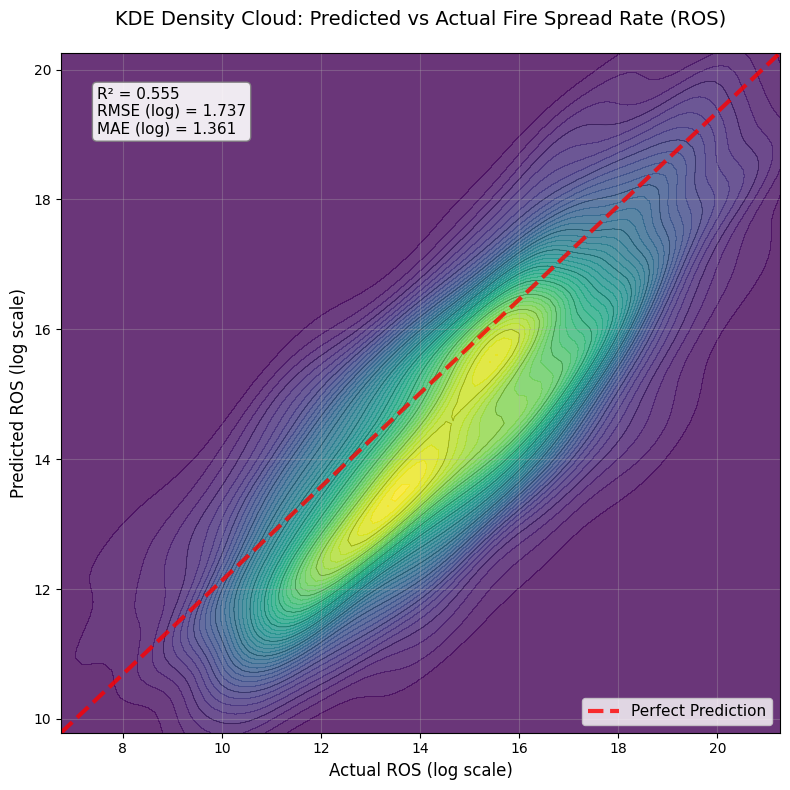

In [ ]:
plt.figure(figsize=(8, 8))

# Create KDE density plot
from scipy.stats import gaussian_kde
import numpy as np

# Calculate the point density
x = all_y_test_log
y = all_y_pred_log
xy = np.vstack([x, y])

# Create meshgrid for density plot
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Calculate KDE on the grid
kde = gaussian_kde(xy)
z = np.reshape(kde(positions).T, xx.shape)

# Plot filled contour (density cloud)
plt.contourf(xx, yy, z, levels=50, cmap='viridis', alpha=0.8)

# Add contour lines for better definition
plt.contour(xx, yy, z, levels=10, colors='black', alpha=0.3, linewidths=0.5)

# Perfect prediction line
plt.plot([xmin, xmax], [ymin, ymax], 'r--', linewidth=3, label='Perfect Prediction', alpha=0.8)

plt.title('KDE Density Cloud: Predicted vs Actual Fire Spread Rate (ROS)', fontsize=14, pad=20)
plt.xlabel('Actual ROS (log scale)', fontsize=12)
plt.ylabel('Predicted ROS (log scale)', fontsize=12)

# Add metrics annotation
plt.text(0.05, 0.95, 
         f'R² = {r2:.3f}\n'
         f'RMSE (log) = {rmse_log:.3f}\n'
         f'MAE (log) = {mae_log:.3f}', 
         transform=plt.gca().transAxes,
         fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### SHAP


SHAP Analysis


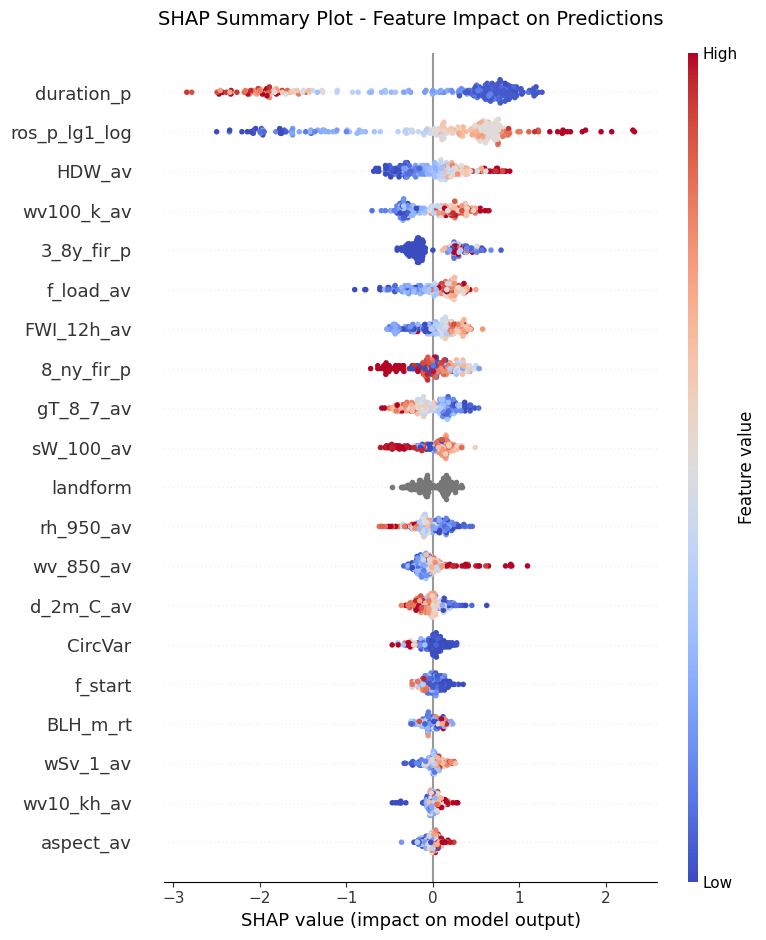

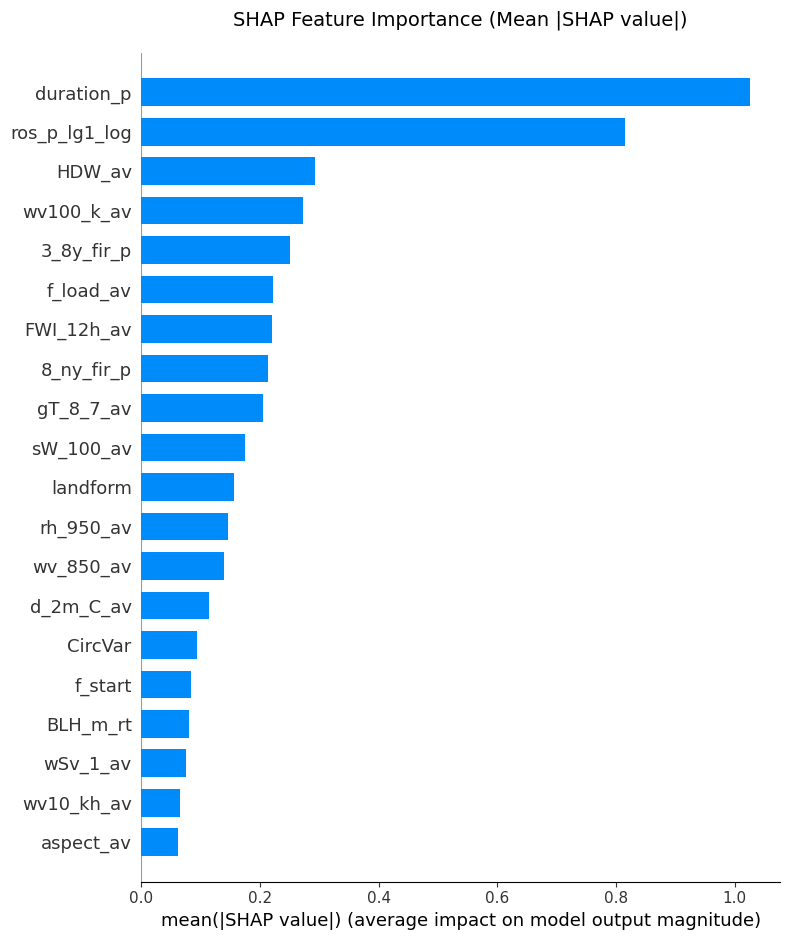

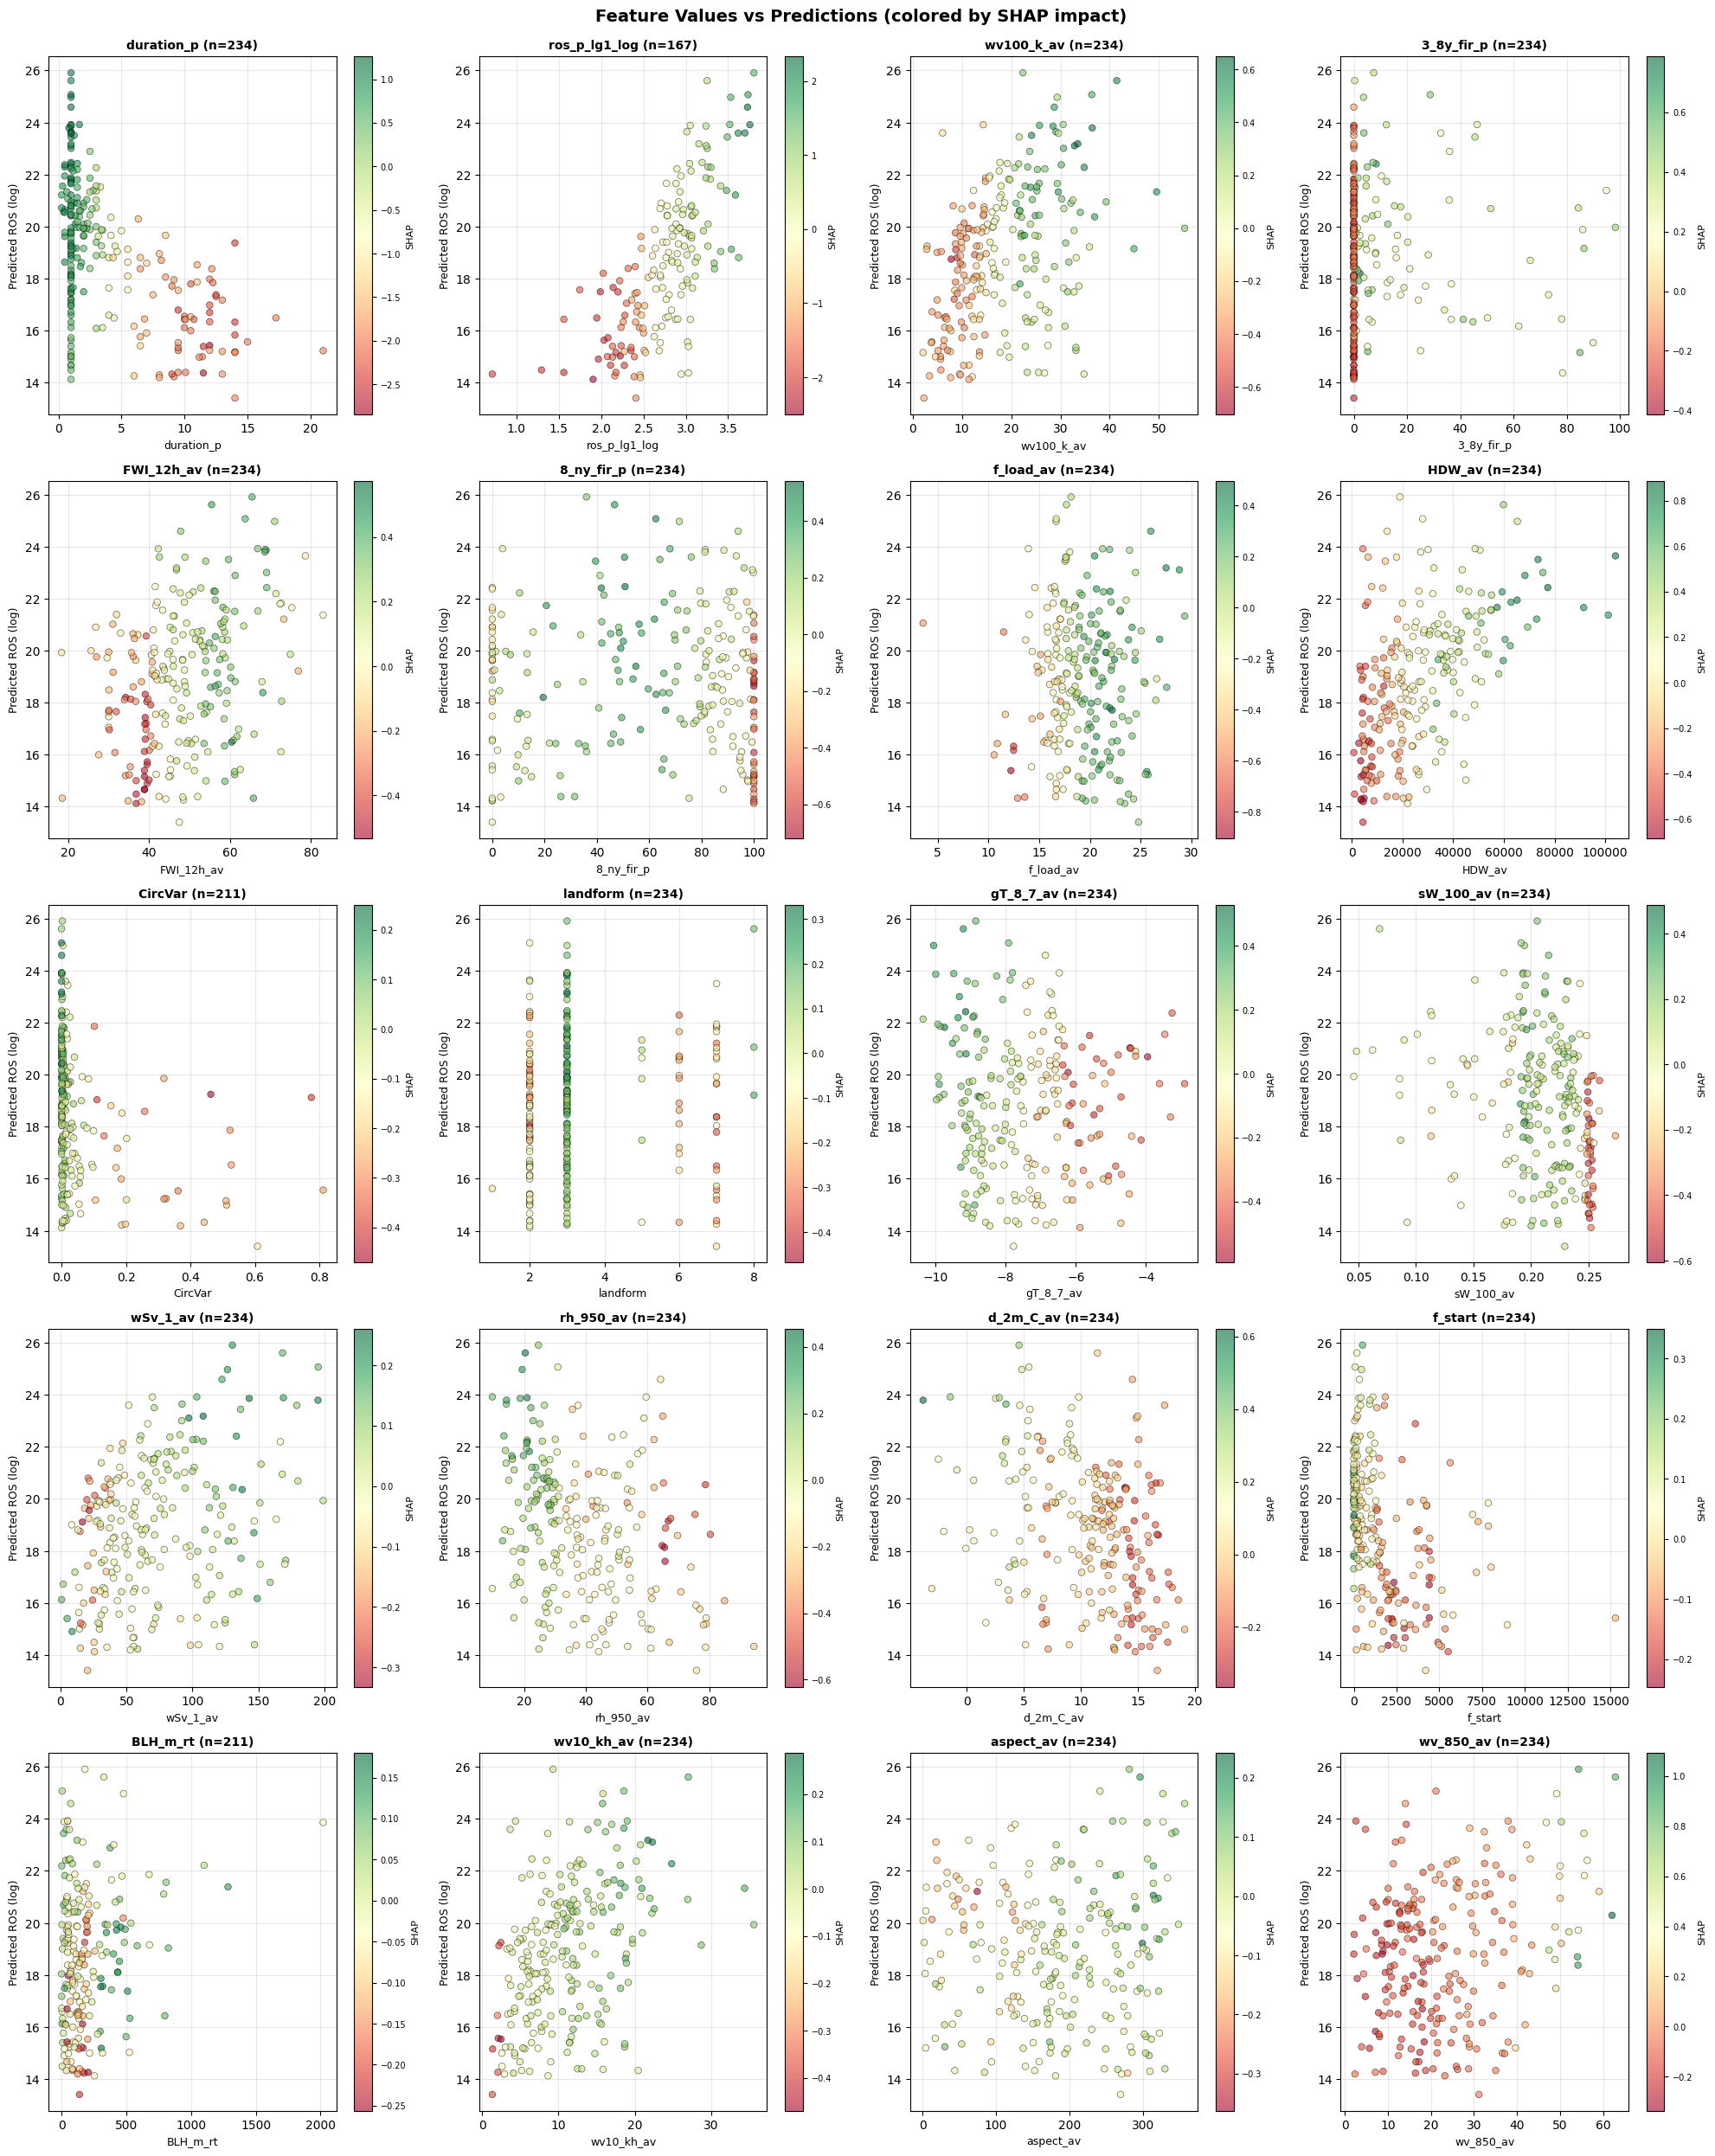

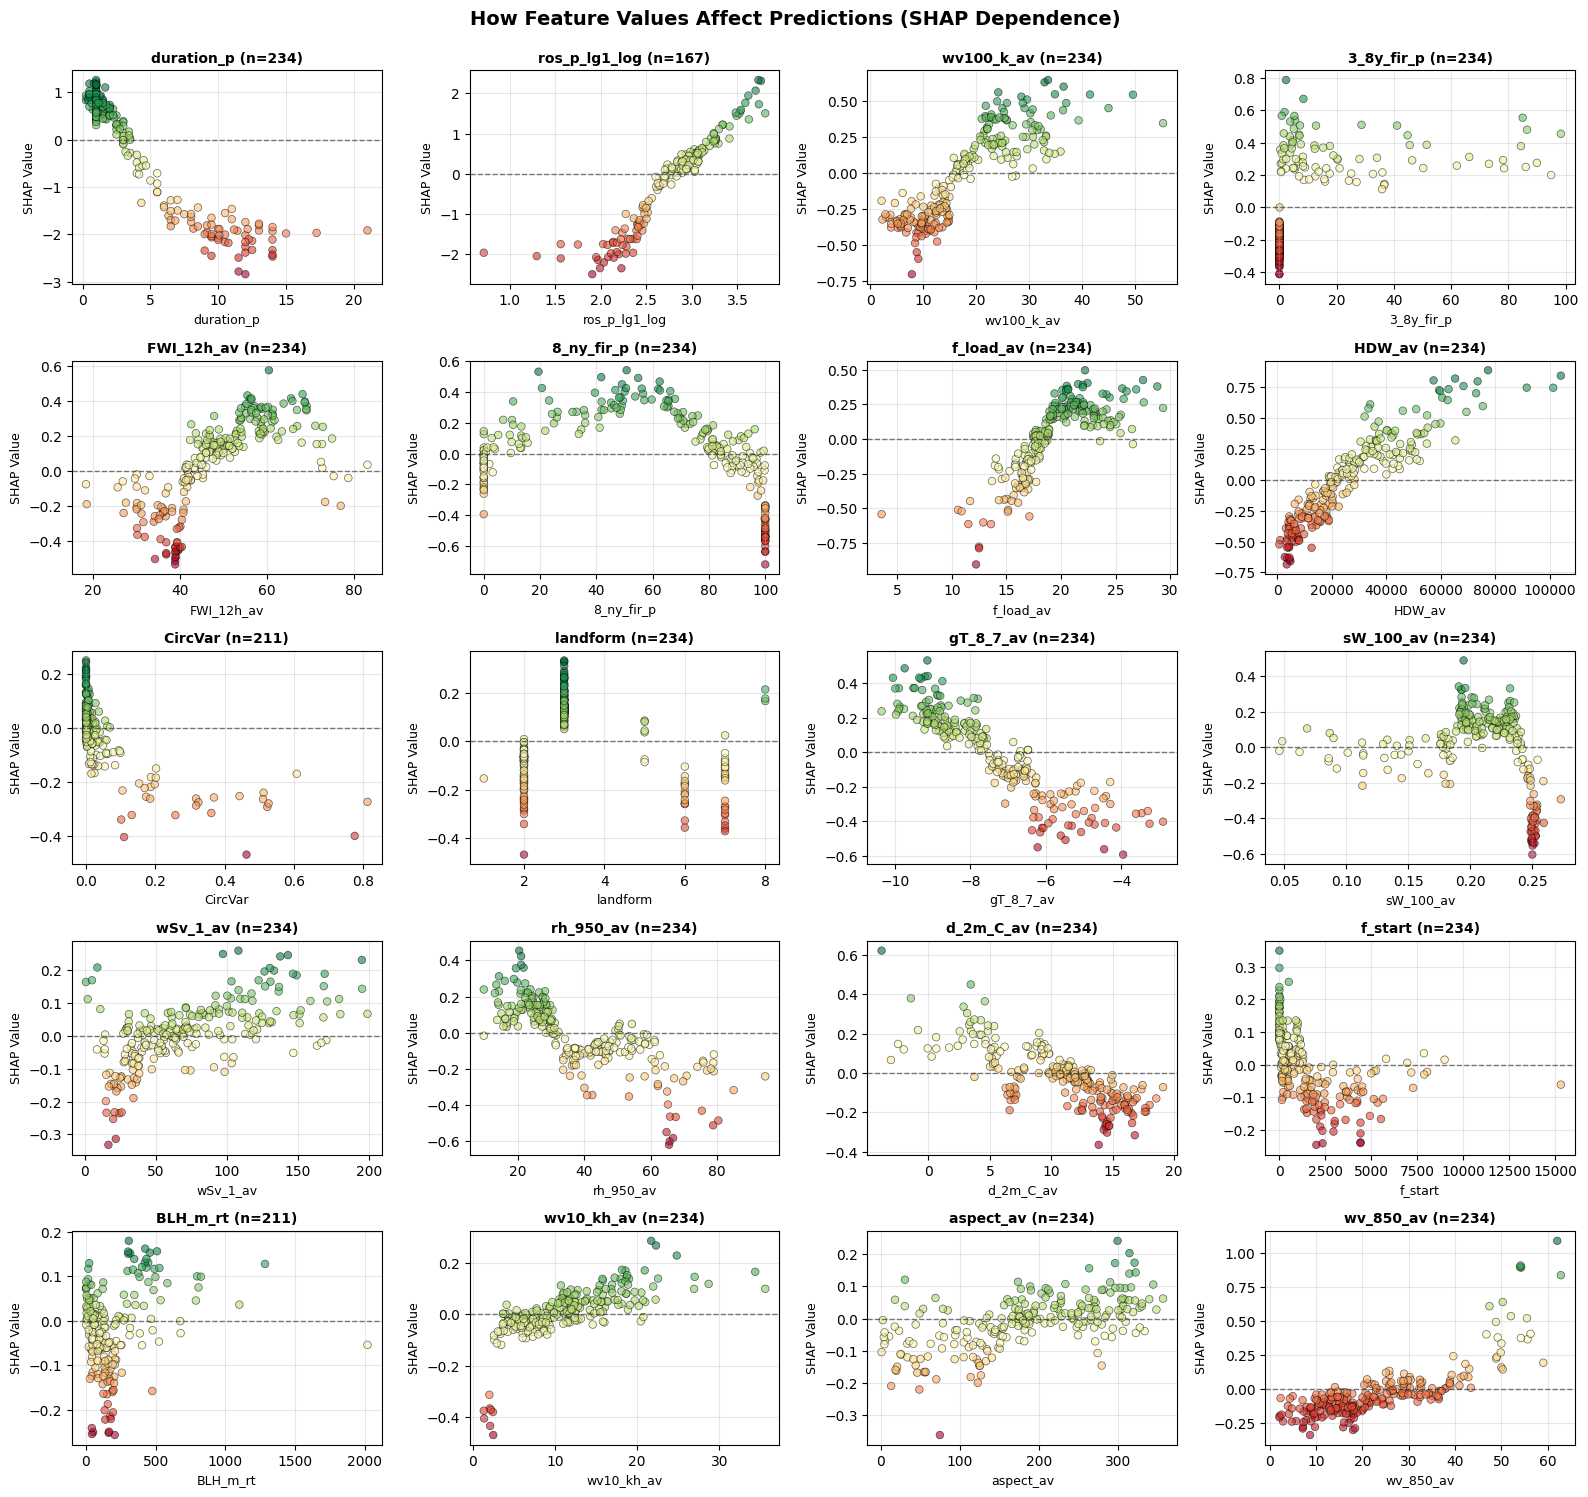


Top 20 Features by Mean |SHAP value|:
          feature  mean_abs_shap
0      duration_p       1.025163
1   ros_p_lg1_log       0.814964
7          HDW_av       0.292839
2      wv100_k_av       0.272165
3      3_8y_fir_p       0.251152
6       f_load_av       0.222155
4      FWI_12h_av       0.219757
5      8_ny_fir_p       0.212477
10      gT_8_7_av       0.205357
11      sW_100_av       0.174278
9        landform       0.155409
13      rh_950_av       0.146001
19      wv_850_av       0.139483
14      d_2m_C_av       0.113816
8         CircVar       0.093652
15        f_start       0.084193
16       BLH_m_rt       0.080158
12       wSv_1_av       0.074910
17     wv10_kh_av       0.064434
18      aspect_av       0.061905

Comparison: XGBoost Importance vs SHAP Importance (Top 15):
          feature  importance  mean_abs_shap
0      duration_p    0.208243       1.025163
1   ros_p_lg1_log    0.160543       0.814964
5          HDW_av    0.047972       0.292839
2      wv100_k_av    0.0774

In [ ]:
print("\n" + "="*50)
print("SHAP Analysis")
print("="*50)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_final)

# 1. Summary Plot - properly handle categorical columns for display
# Create a copy for display that handles NaN coloring
X_test_display = X_test_final.copy()
for col in X_test_display.columns:
    if X_test_display[col].isna().any():
        # Check if column is categorical
        if X_test_display[col].dtype.name == 'category':
            # For categorical, fill with mode (most frequent value)
            mode_val = X_test_display[col].mode()[0] if len(X_test_display[col].mode()) > 0 else X_test_display[col].iloc[0]
            X_test_display[col] = X_test_display[col].fillna(mode_val)
        else:
            # For numeric, fill with median
            X_test_display[col] = X_test_display[col].fillna(X_test_display[col].median())

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_display, plot_type="dot", show=False, cmap='coolwarm')
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Bar Plot (alternative view of feature importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_display, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Get all features
all_features = X_test_final.columns.tolist()
n_features = len(all_features)

# Dynamically calculate rows and columns for subplots
n_cols = 4  # keep 4 columns
n_rows = math.ceil(n_features / n_cols)

# -----------------------------
# 1. Scatter Plots: Feature vs Prediction (colored by SHAP)
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    # Feature values and SHAP values
    feature_values = X_test_final[feature].values
    feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
    
    # Handle different data types for cleaning
    if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
        # For categorical data, check for NaN/None values
        valid_mask = pd.notna(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        y_pred_clean = y_pred_log[valid_mask]
        
        # Convert categorical to numeric for plotting if needed
        if X_test_final[feature].dtype.name == 'category':
            feature_values_clean = pd.Categorical(feature_values_clean).codes
    else:
        # For numerical data, use the original approach
        valid_mask = ~np.isnan(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        y_pred_clean = y_pred_log[valid_mask]
    
    # Scatter plot
    scatter = ax.scatter(
        feature_values_clean,
        y_pred_clean,
        c=feature_shap_clean,
        cmap='RdYlGn',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.set_xlabel(f'{feature}', fontsize=9)
    ax.set_ylabel('Predicted ROS (log)', fontsize=9)
    ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('SHAP', fontsize=8)
    cbar.ax.tick_params(labelsize=7)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Feature Values vs Predictions (colored by SHAP impact)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Dependence Plots: Feature vs SHAP Value
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    feature_values = X_test_final[feature].values
    feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
    
    # Handle different data types for cleaning (FIXED HERE TOO)
    if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
        # For categorical data, check for NaN/None values
        valid_mask = pd.notna(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        
        # Convert categorical to numeric for plotting if needed
        if X_test_final[feature].dtype.name == 'category':
            feature_values_clean = pd.Categorical(feature_values_clean).codes
    else:
        # For numerical data, use the original approach
        valid_mask = ~np.isnan(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
    
    # Scatter plot
    scatter = ax.scatter(
        feature_values_clean,
        feature_shap_clean,
        c=feature_shap_clean,
        cmap='RdYlGn',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Zero line
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel(f'{feature}', fontsize=9)
    ax.set_ylabel('SHAP Value', fontsize=9)
    ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('How Feature Values Affect Predictions (SHAP Dependence)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 6. Mean absolute SHAP values (alternative to feature importance)
shap_importance = pd.DataFrame({
    'feature': X_test_final.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values('mean_abs_shap', ascending=False)

print("\nTop 20 Features by Mean |SHAP value|:")
print(shap_importance.head(20))

# Compare SHAP importance vs XGBoost importance
comparison = importances.merge(
    shap_importance, 
    on='feature', 
    suffixes=('_xgb', '_shap')
)
comparison = comparison.sort_values('mean_abs_shap', ascending=False)

print("\nComparison: XGBoost Importance vs SHAP Importance (Top 15):")
print(comparison[['feature', 'importance', 'mean_abs_shap']].head(15))

# Check for missing values in top features
print("\nMissing values in top 10 features:")
for feature in importances['feature'][:10]:
    missing_count = X_test_final[feature].isna().sum()
    missing_pct = 100 * missing_count / len(X_test_final)
    if missing_count > 0:
        print(f"{feature}: {missing_count} ({missing_pct:.1f}%)")
